# Peak calling testing

In [11]:
from subprocess import Popen, PIPE, DEVNULL
from tempfile import TemporaryDirectory, NamedTemporaryFile
from pathlib import Path
from itertools import product, groupby
from io import StringIO
from collections import deque, namedtuple, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyranges as pr
import pysam
from scripts.get_labels import read_knrgl
from myutils.rmsk import read_rmsk

from tqdm import tqdm

In [12]:
# read in repeatmasker output
rmsk = read_rmsk("/iblm/netapp/data4/mcuoco/sz_slavseq/resources/hs38d1.fa.out")

rep_names = [
    "L1HS_3end",
    "L1PA2_3end",
    "L1PA3_3end",
    "L1PA4_3end",
    "L1PA5_3end",
    "L1PA6_3end",
]

rmsk = rmsk.loc[(rmsk["repName"].isin(rep_names)) & (rmsk["repEnd"] > 860), :]
# rmsk = rmsk.apply(
#     lambda x: x
#     if (x["strand"] == "+" and x["repStart"] < 765)
#     or (x["strand"] == "-" and x["repLeft"] < 765)
#     else None,
#     axis=1,
# ).dropna()

rmsk["genoStart"] = rmsk.apply(
    lambda x: x["genoStart"] - 1000 if x["strand"] == "-" else x["genoStart"], axis=1
)
rmsk["genoEnd"] = rmsk.apply(
    lambda x: x["genoEnd"] + 1000 if x["strand"] == "+" else x["genoEnd"], axis=1
)

rmsk = rmsk.rename(
    columns={
        "genoName": "Chromosome",
        "genoStart": "Start",
        "genoEnd": "End",
        "strand": "Strand",
    }
).loc[:, ["Chromosome", "Start", "End", "Strand"]]
rmsk = rmsk.loc[(rmsk.Start >= 0) & (rmsk.End >= 0), :]

rmsk["Name"] = rmsk.index.values.astype(str)

## Define functions to run `bedtools intersect`

In [13]:
def bam_intersect(bam, bed, view_args=""):
    """
    Intersect bam file with bedfile, optionally filter to bam first.
    Return output as a dataframe
    """
    cmd = f"samtools view -b {bam} {view_args} | bedtools intersect -abam stdin -b {bed} -bed -wa -wb"
    p = Popen(cmd, shell=True, stdout=PIPE, stderr=DEVNULL)

    names = [
        "Chromosome",
        "Start",
        "End",
        "read_id",
        "mapq",
        "Strand",
        "intersect_start",
        "intersect_end",
        "x",
        "y",
        "Flag",
        "z",
        "ChromosomeB",
        "StartB",
        "EndB",
        "NameB",
        "ScoreB",
        "StrandB",
    ]
    with StringIO(p.stdout.read().decode()) as bed:
        df = pd.read_csv(bed, sep="\t", header=None, names=names)

    df.drop(["x", "y", "z"], axis=1, inplace=True)
    df["Flag"] = df["Flag"].str.rstrip(",").astype(int)
    return df


def bed_intersect(peaks, annotation, **kwargs):
    # compute reads per knrgl
    # assert peaks.columns == ["Chromosome", "Start", "End", "Strand", "nreads", "width"], "Incorrect columsn in peak file"

    # save bed files for bedtools
    bed_names = ["Chromosome", "Start", "End", "Name", "Score", "Strand"]
    peak_tmp = NamedTemporaryFile()
    pr.PyRanges(peaks).to_bed(peak_tmp.name)
    peak_names = bed_names + [c for c in peaks.columns if c not in bed_names]

    annotation_tmp = NamedTemporaryFile()
    pr.PyRanges(annotation[["Chromosome", "Start", "End", "Name"]]).to_bed(
        annotation_tmp.name
    )
    annotation_names = [f"{c}b" for c in bed_names] + [
        c for c in annotation.columns if c not in bed_names
    ]

    cmd = f"bedtools intersect -a {peak_tmp.name} -b {annotation_tmp.name} -wa -wb"
    p = Popen(cmd, shell=True, stdout=PIPE)
    with StringIO(p.stdout.read().decode()) as bed:
        df = pd.read_csv(
            bed, sep="\t", header=None, names=peak_names + annotation_names
        )
    peak_tmp.close()
    annotation_tmp.close()

    return df

## Define peak caller

In [14]:
# My custom peak caller
# iterate over reads, cluster overlapping together
# TODO: classify peaks as ref or non-ref based on read2 alignment


# custom tuple to store reads in deque
Read = namedtuple(
    "Read",
    [
        "reference_name",
        "reference_start",
        "reference_end",
        "is_read1",
        "is_read2",
        "is_forward",
        "is_reverse",
        "mapping_quality",
    ],
)


class OverlapPeakCaller:
    def __init__(self, bam: pysam.AlignmentFile) -> None:
        self.bam = bam

    def read_converter(self, read: pysam.AlignedSegment) -> Read:
        "convert pysam.AlignedSegment to namedtuple Read"
        return Read(
            read.reference_name,
            read.reference_start,
            read.reference_end,
            read.is_read1,
            read.is_read2,
            read.is_forward,
            read.is_reverse,
            read.mapping_quality,
        )

    def make_peaks(self, reads, r1_bandwidth=0, min_mapq=60) -> deque:
        """
        Iterate over reads, cluster overlapping reads together
        Do this separately for read1_fwd, read1_rev, read2_fwd, read2_rev
        """

        peak_groups = {
            "read1_fwd": {
                "filter": lambda x: x.is_read1 and x.is_forward,
                "peak": deque(),
                "last_read": None,
            },
            "read1_rev": {
                "filter": lambda x: x.is_read1 and x.is_reverse,
                "peak": deque(),
                "last_read": None,
            },
            "read2_fwd": {
                "filter": lambda x: x.is_read2 and x.is_forward,
                "peak": deque(),
                "last_read": None,
            },
            "read2_rev": {
                "filter": lambda x: x.is_read2 and x.is_reverse,
                "peak": deque(),
                "last_read": None,
            },
        }

        for read in reads:
            for rg, d in peak_groups.items():
                # check if read is in read group
                if not d["filter"](read):
                    continue
                if d["last_read"] is None:
                    d["last_read"] = read
                    d["peak"].append(read)
                    continue

                # if read is not within bandwith of last read, yield peak
                if "read2" in rg:
                    end = d["last_read"].reference_end
                else:
                    end = d["last_read"].reference_end + r1_bandwidth

                if (read.reference_name != d["last_read"].reference_name) or (
                    read.reference_start > end
                ):
                    yield {
                        "read_group": rg,
                        "Chromosome": read.reference_name,
                        "Start": d["peak"][0].reference_start,
                        "End": d["last_read"].reference_end,
                        "Strand": "-" if read.is_reverse else "+",
                        "nreads": len(d["peak"]),
                    }
                    # start new peak
                    d["peak"] = deque()

                d["peak"].append(read)
                d["last_read"] = read

    def merge_peaks(self, peaks, contig, bandwidth=0) -> dict:
        """
        Merge peaks that are within bandwidth of each other for a single contig
        """

        # initialize peak groups dict
        peak_groups = {
            "read1_fwd": None,
            "read2_fwd": None,
            "read1_rev": None,
            "read2_rev": None,
        }

        # iterate over peaks, merging paired peaks and yielding paired and unpaired
        for p in peaks:
            rg = p["read_group"]

            # if peak is unpaired, yield and overwrite
            if peak_groups[rg] is not None:
                yield {
                    "Chromosome": peak_groups[rg]["Chromosome"],
                    "Start": peak_groups[rg]["Start"],
                    "End": peak_groups[rg]["End"],
                    "Strand": "-" if rg == "read1_fwd" or "read2_rev" else "+",
                    "nreads": peak_groups[rg]["nreads"],
                }
            peak_groups[rg] = p

            # try to find paired peak
            for rg1, rg2 in zip(
                ["read1_fwd", "read1_rev", "read2_rev", "read2_fwd"],
                ["read2_rev", "read2_fwd", "read1_fwd", "read1_rev"],
            ):
                if rg == rg1 and (peak_groups[rg2] is not None):
                    # if concordant peak is within bandwidth of last peak, merge and yield
                    if peak_groups[rg1]["Start"] < (
                        peak_groups[rg2]["End"] + bandwidth
                    ):
                        yield {
                            "Chromosome": peak_groups[rg1]["Chromosome"],
                            "Start": peak_groups[rg2]["Start"],
                            "End": peak_groups[rg1]["End"],
                            "Strand": "-" if rg1 == "read1_fwd" or "read2_rev" else "+",
                            "nreads": peak_groups[rg1]["nreads"]
                            + peak_groups[rg2]["nreads"],
                        }
                        # reset
                        peak_groups[rg1] = None
                        peak_groups[rg2] = None

                    # return unmatched peaks
                    else:
                        yield {
                            "Chromosome": peak_groups[rg2]["Chromosome"],
                            "Start": peak_groups[rg2]["Start"],
                            "End": peak_groups[rg2]["End"],
                            "Strand": "-" if rg2 == "read1_fwd" or "read2_rev" else "+",
                            "nreads": peak_groups[rg2]["nreads"],
                        }
                        # reset
                        peak_groups[rg2] = None

    def run(self, contig=None, r1_bandwidth=0, min_mapq=60):

        # get the reads
        reads = filter(
            lambda x: x.is_mapped
            and (not (x.is_secondary or x.is_supplementary))
            and x.mapping_quality >= min_mapq,
            self.bam.fetch(contig=contig),
        )
        reads = map(self.read_converter, reads)

        # get the peaks
        peaks = [p for p in self.make_peaks(reads, r1_bandwidth, min_mapq)]

        # sort peaks, split by contig
        peaks = sorted(peaks, key=lambda x: (x["Chromosome"], x["Start"], x["End"]))
        peaks = {c: list(g) for c, g in groupby(peaks, lambda x: x["Chromosome"])}

        # merge the peaks
        merged = [
            p for c in peaks.keys() for p in self.merge_peaks(peaks[c], r1_bandwidth)
        ]
        merged = sorted(merged, key=lambda x: (x["Chromosome"], x["Start"], x["End"]))

        return peaks, merged

## Define analysis helper functions

In [15]:
# def analysis helper functions
def annotate_peaks(peaks: pd.DataFrame, annotation: pd.DataFrame, name: str):
    """
    Annotate peaks that overlap entries in annotation
    """

    # intersect peaks with annotation
    intersection = bed_intersect(peaks, annotation)
    intersection = (
        intersection[["Chromosome", "Start", "End", "Nameb"]]
        .set_index(["Chromosome", "Start", "End"])
        .rename(columns={"Nameb": f"{name} ID"})
    )

    # annotate peaks
    peaks = peaks.join(intersection, on=["Chromosome", "Start", "End"], how="left")
    peaks[f"{name} cov"] = len(intersection.groupby([f"{name} ID"]).size())
    peaks[name] = len(annotation)

    return peaks

In [16]:
# define plotting helper funciton
def peak_cdf_plot(df, hue_col="indv", split_col="group"):
    # melt df
    df = df.melt(
        id_vars=["Chromosome", "Start", "End", hue_col, split_col],
        value_vars=["nreads", "width"],
        var_name="metric",
        value_name="value",
    )

    # create facetgrid
    g = sns.FacetGrid(
        df,
        col="metric",
        row=split_col,
        hue=hue_col,
        sharex=False,
        sharey=True,
        height=4,
        aspect=1,
    )
    g.map_dataframe(sns.ecdfplot, x="value", stat="proportion")

    # add legend
    g.add_legend()

    # if nreads, set x axis to log scale
    g.axes[0, 0].set_xscale("log")
    g.axes[1, 0].set_xscale("log")

    # if width, set xlim to 0
    g.axes[0, 1].set_xlim(0, None)
    g.axes[1, 1].set_xlim(0, None)

    return g

## Analysis

### Load patient data

In [8]:
# find knrgl bed and bulk BAMs for each individual
individuals = pd.read_csv(
    "/iblm/logglun02/mcuoco/workflows/sz_slavseq/config/bulk_donors.tsv", sep="\t"
)["donor_id"].values.astype(str)
indv_data = {i: {"knrgl": None, "bulk": None} for i in individuals}

for bulk in Path("/iblm/netapp/data4/mcuoco/sz_slavseq/results/align/").rglob(
    "*/gDNA_usd*.sorted.bam"
):
    if bulk.parts[-2] in individuals:
        indv_data[bulk.parts[-2]]["bulk"] = str(bulk)

for knrgl in Path("/iblm/netapp/data4/mcuoco/sz_slavseq/resources/").rglob(
    "*_insertions.bed"
):
    if knrgl.name.split("_")[0] in individuals:
        indv_data[knrgl.name.split("_")[0]]["knrgl"] = str(knrgl)

### test peak caller

In [17]:
# test peak caller
bam = pysam.AlignmentFile(indv_data["27"]["bulk"], "rb")
knrgl = read_knrgl(indv_data["27"]["knrgl"])
knrgl["Name"] = knrgl.index.values.astype(str)  # give each knrgl a unique ID

In [21]:
# call peaks
peaks, merged = OverlapPeakCaller(bam).run(r1_bandwidth=750)
peaks = pd.DataFrame.from_records(
    [peak for contig_peaks in peaks.values() for peak in contig_peaks]
)
peaks["type"] = "unmerged"
merged = pd.DataFrame.from_records(merged)
merged["type"] = "merged"
peaks = pd.concat([peaks, knrgl], axis=1)

# annotate
peaks["width"] = peaks["End"] - peaks["Start"]
peaks = annotate_peaks(peaks, knrgl, "knrgl")
peaks = annotate_peaks(peaks, rmsk, "rmsk")


def label(x):
    # check if float is nan
    if not np.isnan(x["rmsk ID"]):
        return "RMSK"
    elif not np.isnan(x["knrgl ID"]):
        return "KNRGL"
    else:
        return "OTHER"


peaks["label"] = peaks.apply(lambda x: label(x), axis=1)

[Text(0.5, 1.0, 'Merged Peaks')]

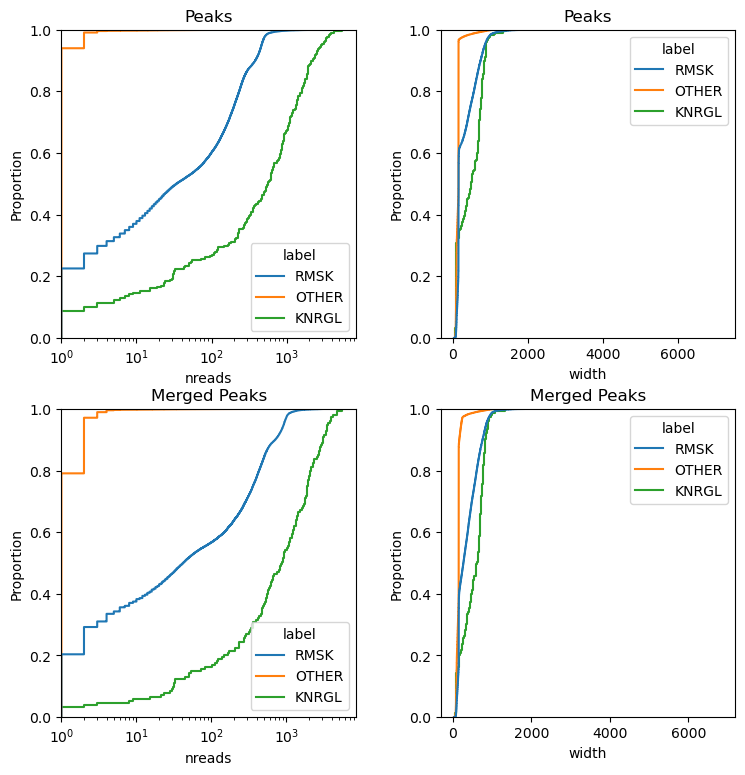

In [20]:
peak_cdf_plot(peaks, hue_col="label", split_col="type")

### Explore `bandwith` and `min_mapq` parameters

Use individual 27

In [ ]:
bandwidths = [250, 500, 1000, 2000]
min_mapqs = [5, 10, 20, 30, 40, 50, 60]
data = indv_data["27"]

total_reads = int(pysam.view("-c", data["bulk"]).rstrip("\n"))
bam = pysam.AlignmentFile(data["bulk"], "rb")
knrgl = read_knrgl(data["knrgl"])
knrgl["Name"] = knrgl.index.values.astype(str)  # give each knrgl a unique ID

res = []
pc = OverlapPeakCaller(bam)
for bw, mq in tqdm(
    product(bandwidths, min_mapqs), total=(len(bandwidths) * len(min_mapqs))
):
    # call peaks
    peaks = pc.run(r1_bandwidth=bw, min_mapq=mq)

    # annotate
    peaks = annotate_peaks(peaks, knrgl, "knrgl")
    peaks = annotate_peaks(peaks, rmsk, "rmsk")

    peaks["bw"] = bw
    peaks["min_mapq"] = mq

    # collect results
    res.append(peaks)

res = pd.concat(res)

In [ ]:
res["frac knrgl cov"] = res["knrgl cov"] / res["knrgl"]
res["frac rmsk cov"] = res["rmsk cov"] / res["rmsk"]
plot_df = (
    res.groupby(["bw", "min_mapq", "frac knrgl cov", "frac rmsk cov"])
    .size()
    .reset_index()
    .rename(columns={0: "total peaks"})
    .melt(
        id_vars=["bw", "min_mapq"],
        value_vars=["total peaks", "frac knrgl cov", "frac rmsk cov"],
        value_name="value",
        var_name="var",
    )
)

sns.catplot(
    data=plot_df,
    x="bw",
    y="value",
    col="var",
    hue="min_mapq",
    kind="bar",
    palette="Set2",
    sharey=False,
    dodge=True,
)

In [ ]:
peak_cdf_plot(res, hue_col="min_mapq")

In [ ]:
peak_cdf_plot(res[res["knrgl ID"].notnull()], hue_col="min_mapq")

### Analyze across individuals

In [ ]:
res = []
for ind, data in tqdm(indv_data.items(), total=len(indv_data)):
    # total_reads = int(pysam.view("-c", data["bulk"], "chr22").rstrip("\n")) # subset to chr22 (for testing)
    total = int(pysam.view("-c", data["bulk"]).rstrip("\n"))
    bam = pysam.AlignmentFile(data["bulk"], "rb")

    # call peaks
    peaks = OverlapPeakCaller(bam).call_peaks()

    ## Compare with knrgl and rmsk
    knrgl = read_knrgl(data["knrgl"])
    knrgl["Name"] = knrgl.index.values.astype(str)  # give each knrgl a unique ID
    peaks = annotate_peaks(peaks, knrgl, "KNRGL")
    peaks = annotate_peaks(peaks, rmsk, "RMSL")

    # collect results
    peaks["indv"] = int(ind)
    peaks["total alignments"] = total
    res.append(peaks)

res = pd.concat(res)

In [ ]:
# add metadata
meta = pd.read_csv(
    "/iblm/logglun02/mcuoco/workflows/sz_slavseq/config/slavseq_metadata.tsv", sep="\t"
)
meta = meta[~meta["TISSUE_ID"].isin(["CommonBrain"])]
meta["indv"] = meta["TISSUE_ID"].str[3:].astype(int)
meta.set_index("indv", inplace=True)

# keep columns of interest
meta = meta[["RACE", "AGE", "DIAGNOSIS"]].drop_duplicates()

# join with res
res = res.join(meta, on="indv")

In [ ]:
# plot
res["frac knrgl cov"] = res["knrgl cov"] / res["knrgl"]
res["frac rmsk cov"] = res["rmsk cov"] / res["rmsk"]
plot_df = (
    res.groupby(
        [
            "indv",
            "total alignments",
            "frac knrgl cov",
            "frac rmsk cov",
            "AGE",
            "RACE",
            "DIAGNOSIS",
        ]
    )
    .size()
    .reset_index()
    .rename(columns={0: "total peaks"})
    .melt(
        id_vars=["indv", "AGE", "RACE", "DIAGNOSIS"],
        value_vars=[
            "total alignments",
            "total peaks",
            "frac knrgl cov",
            "frac rmsk cov",
        ],
        value_name="value",
        var_name="var",
    )
)

sns.catplot(
    data=plot_df,
    x="indv",
    y="value",
    hue="indv",
    col="var",
    kind="bar",
    palette="Set2",
    sharey=False,
    dodge=False,
)

In [ ]:
g = peak_cdf_plot(res)
g.fig.subplots_adjust(top=0.90)
g.fig.suptitle("All peaks")

In [ ]:
g = peak_cdf_plot(res[res["KNRGL_ID"].notnull()])
g.fig.subplots_adjust(top=0.90)
g.fig.suptitle("Peaks overlapping KNRGL")

In [ ]:
g = peak_cdf_plot(res[res["RMSK_ID"].notnull()])
g.fig.subplots_adjust(top=0.90)
g.fig.suptitle("Peaks overlapping RMSK")

In [ ]:
# how many peaks of each type per knrgl insertion?
count = (
    res[["indv", "KNRGL_ID", "read group", "level_1"]]
    .pivot_table(
        index=["indv", "KNRGL_ID"],
        columns="read group",
        values="level_1",
        aggfunc="count",
    )
    .fillna(0)
)
count[["read1_fwd", "read1_rev", "read2_fwd", "read2_rev"]].max(axis=0)

In [ ]:
# how many peaks of each type per knrgl insertion?
count = (
    res[["indv", "KNRGL_ID", "read group", "level_1"]]
    .pivot_table(
        index=["indv", "KNRGL_ID"],
        columns="read group",
        values="level_1",
        aggfunc="count",
    )
    .fillna(0)
)
count[["read1_fwd", "read1_rev", "read2_fwd", "read2_rev"]].sum(axis=1)

Where are the peaks with nreads = 1? Should they be grouped with other peaks or are they artifactual alignments?